In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
import timeit
import os
#from tensorflow.python.ops import math_ops

%matplotlib inline

In [2]:
#%run ./importWalkingDataConfidence_strongerWts.ipynb
%run ./importWalkingDataConfidence.ipynb
tf.logging.set_verbosity(tf.logging.INFO)

Dimension of walking test_x  =  (20, 27)
Dimension of walking train_x =  (650, 27)


./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {
./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {


In [3]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [4]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
sparse_ffp_column =  tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64)
# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime]
#lin_feature_cols = [sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, sparse_ffp_column]
lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, sparse_ffp_column]

In [5]:
LABEL_ID = 0;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [6]:
WT_COL

'happier_wt'

In [7]:
# validation_metrics = {
#     "rmse":
#         tf.metrics.root_mean_squared_error(labels = pd.DataFrame(y_test[LABEL].values),predictions=y_predicted)
# }

In [8]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False),
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500) #200 500 1000
    #metrics=validation_metrics)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [9]:
# Build a wide + deep model
#model_dir_name="/DNN/wideAndDeep/wideMotionBodyAngDeepAllStrngWts_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001"
model_dir_name="/DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001"

# regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
#   dnn_feature_columns=feature_cols, dnn_hidden_units=[1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
#     dnn_optimizer = tf.train.AdamOptimizer(
#       learning_rate=0.01), dnn_dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.softplus)

regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
  dnn_feature_columns=feature_cols, dnn_hidden_units=[10,10],  model_dir=model_dir_name, weight_column_name = WT_COL,
    dnn_optimizer = tf.train.AdamOptimizer(
      learning_rate=0.001), dnn_dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.softplus, fix_global_step_increment_bug=True)

#tf.contrib.layers.xavier_initializer(uniform=True) # this seems more useful for vision stuff where there is lot of fan_in and fan_out

INFO:tensorflow:Using config: {'_num_worker_replicas': 0, '_master': '', '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_environment': 'local', '_save_summary_steps': 100, '_num_ps_replicas': 0, '_model_dir': '/DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000001F6A1A20>, '_task_type': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 1, '_session_config': None, '_task_id': 0, '_is_chief': True, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_evaluation_master': ''}


In [10]:
# Train.
#sess = tf.Session()
#regressor.fit(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000
inputX_train = X_train_all_wts#X_train_all_wts.sample(n = 550, random_state = 0)
inputY_train = y_train#y_train.sample(n = 550, random_state = 0)
regressor.fit(input_fn=get_input_fn(inputX_train, inputY_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:step = 1, loss = 350.363
INFO:tensorflow:Saving checkpoints for 7 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 26 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 27 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 28 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 47 into 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-48
INFO:tensorflow:Finished evaluation at 2017-12-11-22:42:18
INFO:tensorflow:Saving dict for global step 48: global_step = 48, loss = 435.05
INFO:tensorflow:Validation (step 50): loss = 435.05, global_step = 48
INFO:tensorflow:Saving checkpoints for 51 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 52 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 61 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 87 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotio

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-97
INFO:tensorflow:Finished evaluation at 2017-12-11-22:42:30
INFO:tensorflow:Saving dict for global step 97: global_step = 97, loss = 305.846
INFO:tensorflow:Validation (step 100): loss = 305.846, global_step = 97
INFO:tensorflow:Saving checkpoints for 101 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 4.8897
INFO:tensorflow:step = 101, loss = 155.212 (20.452 sec)
INFO:tensorflow:Saving checkpoints for 102 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 109 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ck

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-145
INFO:tensorflow:Finished evaluation at 2017-12-11-22:42:37
INFO:tensorflow:Saving dict for global step 145: global_step = 145, loss = 185.008
INFO:tensorflow:Validation (step 150): loss = 185.008, global_step = 145
INFO:tensorflow:Saving checkpoints for 151 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 152 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 174 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scal

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-174
INFO:tensorflow:Finished evaluation at 2017-12-11-22:42:41
INFO:tensorflow:Saving dict for global step 174: global_step = 174, loss = 117.551
INFO:tensorflow:Validation (step 200): loss = 117.551, global_step = 174
INFO:tensorflow:Saving checkpoints for 201 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 9.23991
INFO:tensorflow:step = 201, loss = 35.8216 (10.823 sec)
INFO:tensorflow:Saving checkpoints for 202 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 207 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\mod

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-239
INFO:tensorflow:Finished evaluation at 2017-12-11-22:42:46
INFO:tensorflow:Saving dict for global step 239: global_step = 239, loss = 36.9764
INFO:tensorflow:Validation (step 250): loss = 36.9764, global_step = 239
INFO:tensorflow:Saving checkpoints for 251 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 252 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 269 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 272 into /DNNNew/DNNHappy/wideAndDeep/happyData65

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-291
INFO:tensorflow:Finished evaluation at 2017-12-11-22:42:54
INFO:tensorflow:Saving dict for global step 291: global_step = 291, loss = 26.7541
INFO:tensorflow:Validation (step 300): loss = 26.7541, global_step = 291
INFO:tensorflow:Saving checkpoints for 301 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 7.7359
INFO:tensorflow:step = 301, loss = 25.2571 (12.934 sec)
INFO:tensorflow:Saving checkpoints for 304 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 305 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\mode

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:43:03
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-329
INFO:tensorflow:Finished evaluation at 2017-12-11-22:43:03
INFO:tensorflow:Saving dict for global step 329: global_step = 329, loss = 22.9165
INFO:tensorflow:Validation (step 350): loss = 22.9165, global_step = 329
INFO:tensorflow:Saving checkpoints for 351 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 366 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 367 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-380
INFO:tensorflow:Finished evaluation at 2017-12-11-22:43:08
INFO:tensorflow:Saving dict for global step 380: global_step = 380, loss = 19.1005
INFO:tensorflow:Validation (step 400): loss = 19.1005, global_step = 380
INFO:tensorflow:Saving checkpoints for 401 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 6.94742
INFO:tensorflow:step = 401, loss = 16.8023 (14.387 sec)
INFO:tensorflow:Saving checkpoints for 419 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 420 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\mod

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-420
INFO:tensorflow:Finished evaluation at 2017-12-11-22:43:12
INFO:tensorflow:Saving dict for global step 420: global_step = 420, loss = 17.3583
INFO:tensorflow:Validation (step 450): loss = 17.3583, global_step = 420
INFO:tensorflow:Saving checkpoints for 451 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 452 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 469 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 480 into /DNNNew/DNNHappy/wideAndDeep/happyData65

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:43:19
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-494
INFO:tensorflow:Finished evaluation at 2017-12-11-22:43:19
INFO:tensorflow:Saving dict for global step 494: global_step = 494, loss = 15.0656
INFO:tensorflow:Validation (step 500): loss = 15.0656, global_step = 494
INFO:tensorflow:Saving checkpoints for 501 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 9.08956
INFO:tensorflow:step = 501, loss = 16.8299 (11.002 sec)
INFO:tensorflow:Saving checkpoints for 511 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 512 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngD

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-538
INFO:tensorflow:Finished evaluation at 2017-12-11-22:43:26
INFO:tensorflow:Saving dict for global step 538: global_step = 538, loss = 14.4847
INFO:tensorflow:Validation (step 550): loss = 14.4847, global_step = 538
INFO:tensorflow:Saving checkpoints for 551 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 569 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 570 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 583 into /DNNNew/DNNHappy/wideAndDeep/happyData65

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-600
INFO:tensorflow:Finished evaluation at 2017-12-11-22:43:32
INFO:tensorflow:Saving dict for global step 600: global_step = 600, loss = 13.9198
INFO:tensorflow:Validation (step 600): loss = 13.9198, global_step = 600
INFO:tensorflow:Saving checkpoints for 601 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 7.72515
INFO:tensorflow:step = 601, loss = 16.6036 (12.952 sec)
INFO:tensorflow:Saving checkpoints for 614 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 615 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\mod

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-633
INFO:tensorflow:Finished evaluation at 2017-12-11-22:43:38
INFO:tensorflow:Saving dict for global step 633: global_step = 633, loss = 13.8128
INFO:tensorflow:Validation (step 650): loss = 13.8128, global_step = 633
INFO:tensorflow:Saving checkpoints for 651 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 665 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 666 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 684 into /DNNNew/DNNHappy/wideAndDeep/happyData65

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-700
INFO:tensorflow:Finished evaluation at 2017-12-11-22:43:55
INFO:tensorflow:Saving dict for global step 700: global_step = 700, loss = 13.2027
INFO:tensorflow:Validation (step 700): loss = 13.2027, global_step = 700
INFO:tensorflow:Saving checkpoints for 701 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 4.28223
INFO:tensorflow:step = 701, loss = 14.8407 (23.345 sec)
INFO:tensorflow:Saving checkpoints for 702 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 703 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\mod

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-726
INFO:tensorflow:Finished evaluation at 2017-12-11-22:44:02
INFO:tensorflow:Saving dict for global step 726: global_step = 726, loss = 13.3656
INFO:tensorflow:Validation (step 750): loss = 13.3656, global_step = 726
INFO:tensorflow:Saving checkpoints for 751 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 752 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 753 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 754 into /DNNNew/DNNHappy/wideAndDeep/happyData65

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-800
INFO:tensorflow:Finished evaluation at 2017-12-11-22:44:28
INFO:tensorflow:Saving dict for global step 800: global_step = 800, loss = 13.3636
INFO:tensorflow:Validation (step 800): loss = 13.3636, global_step = 800
INFO:tensorflow:Saving checkpoints for 801 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 3.08615
INFO:tensorflow:step = 801, loss = 17.6486 (32.403 sec)
INFO:tensorflow:Saving checkpoints for 810 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 811 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\mod

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-845
INFO:tensorflow:Finished evaluation at 2017-12-11-22:44:38
INFO:tensorflow:Saving dict for global step 845: global_step = 845, loss = 12.843
INFO:tensorflow:Validation (step 850): loss = 12.843, global_step = 845
INFO:tensorflow:Saving checkpoints for 851 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 852 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 865 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 866 into /DNNNew/DNNHappy/wideAndDeep/happyData650_

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-889
INFO:tensorflow:Finished evaluation at 2017-12-11-22:44:44
INFO:tensorflow:Saving dict for global step 889: global_step = 889, loss = 13.1558
INFO:tensorflow:Validation (step 900): loss = 13.1558, global_step = 889
INFO:tensorflow:Saving checkpoints for 901 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 6.23834
INFO:tensorflow:step = 901, loss = 15.7269 (16.030 sec)
INFO:tensorflow:Saving checkpoints for 902 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 908 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\mod

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-909
INFO:tensorflow:Finished evaluation at 2017-12-11-22:44:49
INFO:tensorflow:Saving dict for global step 909: global_step = 909, loss = 13.3524
INFO:tensorflow:Validation (step 950): loss = 13.3524, global_step = 909
INFO:tensorflow:Saving checkpoints for 951 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 952 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 976 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 982 into /DNNNew/DNNHappy/wideAndDeep/happyData65

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-987
INFO:tensorflow:Finished evaluation at 2017-12-11-22:44:59
INFO:tensorflow:Saving dict for global step 987: global_step = 987, loss = 12.6356
INFO:tensorflow:Validation (step 1000): loss = 12.6356, global_step = 987
INFO:tensorflow:Saving checkpoints for 1001 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 6.40578
INFO:tensorflow:step = 1001, loss = 17.1647 (15.612 sec)
INFO:tensorflow:Saving checkpoints for 1002 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1009 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR00

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1050
INFO:tensorflow:Finished evaluation at 2017-12-11-22:45:08
INFO:tensorflow:Saving dict for global step 1050: global_step = 1050, loss = 12.1753
INFO:tensorflow:Validation (step 1050): loss = 12.1753, global_step = 1050
INFO:tensorflow:Saving checkpoints for 1051 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1052 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1081 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1081
INFO:tensorflow:Finished evaluation at 2017-12-11-22:45:12
INFO:tensorflow:Saving dict for global step 1081: global_step = 1081, loss = 12.3941
INFO:tensorflow:Validation (step 1100): loss = 12.3941, global_step = 1081
INFO:tensorflow:Saving checkpoints for 1101 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 8.09015
INFO:tensorflow:step = 1101, loss = 18.1169 (12.359 sec)
INFO:tensorflow:Saving checkpoints for 1102 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1103 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1138
INFO:tensorflow:Finished evaluation at 2017-12-11-22:45:21
INFO:tensorflow:Saving dict for global step 1138: global_step = 1138, loss = 12.0777
INFO:tensorflow:Validation (step 1150): loss = 12.0777, global_step = 1138
INFO:tensorflow:Saving checkpoints for 1151 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1167 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1168 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1168
INFO:tensorflow:Finished evaluation at 2017-12-11-22:45:25
INFO:tensorflow:Saving dict for global step 1168: global_step = 1168, loss = 12.6353
INFO:tensorflow:Validation (step 1200): loss = 12.6353, global_step = 1168
INFO:tensorflow:Saving checkpoints for 1201 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 7.39275
INFO:tensorflow:step = 1201, loss = 18.0097 (13.532 sec)
INFO:tensorflow:Saving checkpoints for 1202 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1208 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1248
INFO:tensorflow:Finished evaluation at 2017-12-11-22:45:37
INFO:tensorflow:Saving dict for global step 1248: global_step = 1248, loss = 12.4422
INFO:tensorflow:Validation (step 1250): loss = 12.4422, global_step = 1248
INFO:tensorflow:Saving checkpoints for 1251 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1260 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1261 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1274 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1298
INFO:tensorflow:Finished evaluation at 2017-12-11-22:45:47
INFO:tensorflow:Saving dict for global step 1298: global_step = 1298, loss = 12.4466
INFO:tensorflow:Validation (step 1300): loss = 12.4466, global_step = 1298
INFO:tensorflow:Saving checkpoints for 1301 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 4.5647
INFO:tensorflow:step = 1301, loss = 17.0536 (21.903 sec)
INFO:tensorflow:Saving checkpoints for 1302 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1303 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1350
INFO:tensorflow:Finished evaluation at 2017-12-11-22:46:10
INFO:tensorflow:Saving dict for global step 1350: global_step = 1350, loss = 12.0106
INFO:tensorflow:Validation (step 1350): loss = 12.0106, global_step = 1350
INFO:tensorflow:Saving checkpoints for 1351 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1352 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1353 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1354 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1383
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:08
INFO:tensorflow:Saving dict for global step 1383: global_step = 1383, loss = 11.9775
INFO:tensorflow:Validation (step 1400): loss = 11.9775, global_step = 1383
INFO:tensorflow:Saving checkpoints for 1401 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 1.23998
INFO:tensorflow:step = 1401, loss = 17.1177 (80.647 sec)
INFO:tensorflow:Saving checkpoints for 1430 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1431 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1432
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:13
INFO:tensorflow:Saving dict for global step 1432: global_step = 1432, loss = 12.1784
INFO:tensorflow:Validation (step 1450): loss = 12.1784, global_step = 1432
INFO:tensorflow:Saving checkpoints for 1451 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1452 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1481 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1490 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1491
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:19
INFO:tensorflow:Saving dict for global step 1491: global_step = 1491, loss = 11.6614
INFO:tensorflow:Validation (step 1500): loss = 11.6614, global_step = 1491
INFO:tensorflow:Saving checkpoints for 1501 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 9.05253
INFO:tensorflow:step = 1501, loss = 15.965 (11.047 sec)
INFO:tensorflow:Saving checkpoints for 1550 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow wi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1550
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:22
INFO:tensorflow:Saving dict for global step 1550: global_step = 1550, loss = 11.4969
INFO:tensorflow:Validation (step 1550): loss = 11.4969, global_step = 1550
INFO:tensorflow:Saving checkpoints for 1551 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1552 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1573 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1574 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1574
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:27
INFO:tensorflow:Saving dict for global step 1574: global_step = 1574, loss = 11.3868
INFO:tensorflow:Validation (step 1600): loss = 11.3868, global_step = 1574
INFO:tensorflow:Saving checkpoints for 1601 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 12.4666
INFO:tensorflow:step = 1601, loss = 17.2618 (8.021 sec)
INFO:tensorflow:Saving checkpoints for 1602 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1603 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1636
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:34
INFO:tensorflow:Saving dict for global step 1636: global_step = 1636, loss = 12.1063
INFO:tensorflow:Validation (step 1650): loss = 12.1063, global_step = 1636
INFO:tensorflow:Saving checkpoints for 1651 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1652 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1656 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1676 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1700
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:44
INFO:tensorflow:Saving dict for global step 1700: global_step = 1700, loss = 12.173
INFO:tensorflow:Validation (step 1700): loss = 12.173, global_step = 1700
INFO:tensorflow:Saving checkpoints for 1701 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 5.8035
INFO:tensorflow:step = 1701, loss = 14.8782 (17.232 sec)
INFO:tensorflow:Saving checkpoints for 1702 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1719 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR0

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1719
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:48
INFO:tensorflow:Saving dict for global step 1719: global_step = 1719, loss = 12.0845
INFO:tensorflow:Validation (step 1750): loss = 12.0845, global_step = 1719
INFO:tensorflow:Saving checkpoints for 1751 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1752 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1795 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1795
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:52
INFO:tensorflow:Saving dict for global step 1795: global_step = 1795, loss = 11.6365
INFO:tensorflow:Validation (step 1800): loss = 11.6365, global_step = 1795
INFO:tensorflow:Saving checkpoints for 1801 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 12.7772
INFO:tensorflow:step = 1801, loss = 15.3647 (7.825 sec)
INFO:tensorflow:Saving checkpoints for 1816 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow wi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:47:55
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1816
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:55
INFO:tensorflow:Saving dict for global step 1816: global_step = 1816, loss = 11.6582
INFO:tensorflow:Validation (step 1850): loss = 11.6582, global_step = 1816
INFO:tensorflow:Saving checkpoints for 1851 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1851
INFO:tensorflow:Finished evaluation at 2017-12-11-22:47:57
INFO:tensorflow:Saving dict for global step 1851: global_step = 1851, loss = 11.3674
INFO:tensorflow:Validation (step 1900): loss = 11.3674, global_step = 1851
INFO:tensorflow:Saving checkpoints for 1901 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 20.4487
INFO:tensorflow:step = 1901, loss = 14.6781 (4.889 sec)
INFO:tensorflow:Saving checkpoints for 1902 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1925 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1938
INFO:tensorflow:Finished evaluation at 2017-12-11-22:48:02
INFO:tensorflow:Saving dict for global step 1938: global_step = 1938, loss = 11.2929
INFO:tensorflow:Validation (step 1950): loss = 11.2929, global_step = 1938
INFO:tensorflow:Saving checkpoints for 1951 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1952 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1991 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1992 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-1992
INFO:tensorflow:Finished evaluation at 2017-12-11-22:48:07
INFO:tensorflow:Saving dict for global step 1992: global_step = 1992, loss = 11.0034
INFO:tensorflow:Validation (step 2000): loss = 11.0034, global_step = 1992
INFO:tensorflow:Saving checkpoints for 2001 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 9.90631
INFO:tensorflow:step = 2001, loss = 16.8586 (10.122 sec)
INFO:tensorflow:Saving checkpoints for 2002 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2003 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2047
INFO:tensorflow:Finished evaluation at 2017-12-11-22:48:13
INFO:tensorflow:Saving dict for global step 2047: global_step = 2047, loss = 11.5588
INFO:tensorflow:Validation (step 2050): loss = 11.5588, global_step = 2047
INFO:tensorflow:Saving checkpoints for 2051 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2052 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2053 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2054 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2096
INFO:tensorflow:Finished evaluation at 2017-12-11-22:48:38
INFO:tensorflow:Saving dict for global step 2096: global_step = 2096, loss = 11.2814
INFO:tensorflow:Validation (step 2100): loss = 11.2814, global_step = 2096
INFO:tensorflow:Saving checkpoints for 2101 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 3.1824
INFO:tensorflow:step = 2101, loss = 16.7322 (31.397 sec)
INFO:tensorflow:Saving checkpoints for 2102 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2120 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2148
INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:10
INFO:tensorflow:Saving dict for global step 2148: global_step = 2148, loss = 11.3808
INFO:tensorflow:Validation (step 2150): loss = 11.3808, global_step = 2148
INFO:tensorflow:Saving checkpoints for 2151 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2152 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2171 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2172 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:49:19
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2196
INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:19
INFO:tensorflow:Saving dict for global step 2196: global_step = 2196, loss = 10.9532
INFO:tensorflow:Validation (step 2200): loss = 10.9532, global_step = 2196
INFO:tensorflow:Saving checkpoints for 2201 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 2.46571
INFO:tensorflow:step = 2201, loss = 17.2543 (40.555 sec)
INFO:tensorflow:Saving checkpoints for 2236 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2237 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMoti

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2237
INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:23
INFO:tensorflow:Saving dict for global step 2237: global_step = 2237, loss = 11.2671
INFO:tensorflow:Validation (step 2250): loss = 11.2671, global_step = 2237
INFO:tensorflow:Saving checkpoints for 2251 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2287 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2288 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2288
INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:27
INFO:tensorflow:Saving dict for global step 2288: global_step = 2288, loss = 11.4389
INFO:tensorflow:Validation (step 2300): loss = 11.4389, global_step = 2288
INFO:tensorflow:Saving checkpoints for 2301 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 12.7365
INFO:tensorflow:step = 2301, loss = 16.8012 (7.860 sec)
INFO:tensorflow:Saving checkpoints for 2302 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow wi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2302
INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:30
INFO:tensorflow:Saving dict for global step 2302: global_step = 2302, loss = 11.332
INFO:tensorflow:Validation (step 2350): loss = 11.332, global_step = 2302
INFO:tensorflow:Saving checkpoints for 2351 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2365 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:33
INFO:tensorflow:Saving dict for global step 2365: global_step = 2365, loss = 11.0259
INFO:tensorflow:Validation (step 2400): loss = 11.0259, global_step = 2365
INFO:tensorflow:Saving checkpoints for 2401 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 17.1841
INFO:tensorflow:step = 2401, loss = 14.688 (5.819 sec)
INFO:tensorflow:Saving checkpoints for 2402 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2403 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2404 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlySt

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2438
INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:47
INFO:tensorflow:Saving dict for global step 2438: global_step = 2438, loss = 11.062
INFO:tensorflow:Validation (step 2450): loss = 11.062, global_step = 2438
INFO:tensorflow:Saving checkpoints for 2451 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2489 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2490 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summar

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:49:51
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2490
INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:51
INFO:tensorflow:Saving dict for global step 2490: global_step = 2490, loss = 11.0604
INFO:tensorflow:Validation (step 2500): loss = 11.0604, global_step = 2490
INFO:tensorflow:Saving checkpoints for 2501 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 5.35502
INFO:tensorflow:step = 2501, loss = 14.5189 (18.666 sec)
INFO:tensorflow:Saving checkpoints for 2522 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2523 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMoti

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2537
INFO:tensorflow:Finished evaluation at 2017-12-11-22:49:59
INFO:tensorflow:Saving dict for global step 2537: global_step = 2537, loss = 10.7549
INFO:tensorflow:Validation (step 2550): loss = 10.7549, global_step = 2537
INFO:tensorflow:Saving checkpoints for 2551 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2552 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2553 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2571 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2585
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:12
INFO:tensorflow:Saving dict for global step 2585: global_step = 2585, loss = 10.8724
INFO:tensorflow:Validation (step 2600): loss = 10.8724, global_step = 2585
INFO:tensorflow:Saving checkpoints for 2601 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 4.76254
INFO:tensorflow:step = 2601, loss = 13.6604 (20.997 sec)
INFO:tensorflow:Saving checkpoints for 2602 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2644 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2644
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:16
INFO:tensorflow:Saving dict for global step 2644: global_step = 2644, loss = 10.7507
INFO:tensorflow:Validation (step 2650): loss = 10.7507, global_step = 2644
INFO:tensorflow:Saving checkpoints for 2651 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2652 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2674 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2674
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:20
INFO:tensorflow:Saving dict for global step 2674: global_step = 2674, loss = 10.891
INFO:tensorflow:Validation (step 2700): loss = 10.891, global_step = 2674
INFO:tensorflow:Saving checkpoints for 2701 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 13.1433
INFO:tensorflow:step = 2701, loss = 15.0966 (7.608 sec)
INFO:tensorflow:Saving checkpoints for 2740 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:50:22
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2740
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:23
INFO:tensorflow:Saving dict for global step 2740: global_step = 2740, loss = 10.925
INFO:tensorflow:Validation (step 2750): loss = 10.925, global_step = 2740
INFO:tensorflow:Saving checkpoints for 2751 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2778 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2779 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updati

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2779
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:27
INFO:tensorflow:Saving dict for global step 2779: global_step = 2779, loss = 10.6861
INFO:tensorflow:Validation (step 2800): loss = 10.6861, global_step = 2779
INFO:tensorflow:Saving checkpoints for 2801 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 14.5934
INFO:tensorflow:step = 2801, loss = 13.5623 (6.852 sec)
INFO:tensorflow:Saving checkpoints for 2802 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2803 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2846
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:33
INFO:tensorflow:Saving dict for global step 2846: global_step = 2846, loss = 10.8403
INFO:tensorflow:Validation (step 2850): loss = 10.8403, global_step = 2846
INFO:tensorflow:Saving checkpoints for 2851 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2854 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2855 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2856 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2890
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:43
INFO:tensorflow:Saving dict for global step 2890: global_step = 2890, loss = 10.5741
INFO:tensorflow:Validation (step 2900): loss = 10.5741, global_step = 2890
INFO:tensorflow:Saving checkpoints for 2901 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 6.11511
INFO:tensorflow:step = 2901, loss = 12.9315 (16.353 sec)
INFO:tensorflow:Saving checkpoints for 2902 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2935 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2935
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:47
INFO:tensorflow:Saving dict for global step 2935: global_step = 2935, loss = 11.1075
INFO:tensorflow:Validation (step 2950): loss = 11.1075, global_step = 2935
INFO:tensorflow:Saving checkpoints for 2951 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2976 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2977 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-2977
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:51
INFO:tensorflow:Saving dict for global step 2977: global_step = 2977, loss = 10.7828
INFO:tensorflow:Validation (step 3000): loss = 10.7828, global_step = 2977
INFO:tensorflow:Saving checkpoints for 3001 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 12.9762
INFO:tensorflow:step = 3001, loss = 15.1861 (7.706 sec)
INFO:tensorflow:Saving checkpoints for 3002 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow wi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3002
INFO:tensorflow:Finished evaluation at 2017-12-11-22:50:54
INFO:tensorflow:Saving dict for global step 3002: global_step = 3002, loss = 11.2381
INFO:tensorflow:Validation (step 3050): loss = 11.2381, global_step = 3002
INFO:tensorflow:Saving checkpoints for 3051 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3052 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3053 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3060 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3082
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:00
INFO:tensorflow:Saving dict for global step 3082: global_step = 3082, loss = 10.728
INFO:tensorflow:Validation (step 3100): loss = 10.728, global_step = 3082
INFO:tensorflow:Saving checkpoints for 3101 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 11.134
INFO:tensorflow:step = 3101, loss = 15.2475 (8.990 sec)
INFO:tensorflow:Saving checkpoints for 3102 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3102
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:03
INFO:tensorflow:Saving dict for global step 3102: global_step = 3102, loss = 10.5144
INFO:tensorflow:Validation (step 3150): loss = 10.5144, global_step = 3102
INFO:tensorflow:Saving checkpoints for 3151 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3152 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3198 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3199 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:51:08
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3200
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:09
INFO:tensorflow:Saving dict for global step 3200: global_step = 3200, loss = 10.647
INFO:tensorflow:Validation (step 3200): loss = 10.647, global_step = 3200
INFO:tensorflow:Saving checkpoints for 3201 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 11.1439
INFO:tensorflow:step = 3201, loss = 13.6994 (8.966 sec)
INFO:tensorflow:Saving checkpoints for 3202 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3203 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionB

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3239
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:15
INFO:tensorflow:Saving dict for global step 3239: global_step = 3239, loss = 10.6975
INFO:tensorflow:Validation (step 3250): loss = 10.6975, global_step = 3239
INFO:tensorflow:Saving checkpoints for 3251 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3252 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3279 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3286 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:51:19
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3286
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:20
INFO:tensorflow:Saving dict for global step 3286: global_step = 3286, loss = 10.7332
INFO:tensorflow:Validation (step 3300): loss = 10.7332, global_step = 3286
INFO:tensorflow:Saving checkpoints for 3301 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 9.09701
INFO:tensorflow:step = 3301, loss = 16.0718 (10.995 sec)
INFO:tensorflow:Saving checkpoints for 3302 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3303 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMoti

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3303
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:24
INFO:tensorflow:Saving dict for global step 3303: global_step = 3303, loss = 10.4477
INFO:tensorflow:Validation (step 3350): loss = 10.4477, global_step = 3303
INFO:tensorflow:Saving checkpoints for 3351 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3382 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3394 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3394
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:28
INFO:tensorflow:Saving dict for global step 3394: global_step = 3394, loss = 10.6001
INFO:tensorflow:Validation (step 3400): loss = 10.6001, global_step = 3394
INFO:tensorflow:Saving checkpoints for 3401 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 12.7805
INFO:tensorflow:step = 3401, loss = 15.5136 (7.822 sec)
INFO:tensorflow:Saving checkpoints for 3402 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3423 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3423
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:31
INFO:tensorflow:Saving dict for global step 3423: global_step = 3423, loss = 10.3642
INFO:tensorflow:Validation (step 3450): loss = 10.3642, global_step = 3423
INFO:tensorflow:Saving checkpoints for 3451 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3452 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3453 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3454 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3487
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:41
INFO:tensorflow:Saving dict for global step 3487: global_step = 3487, loss = 10.6126
INFO:tensorflow:Validation (step 3500): loss = 10.6126, global_step = 3487
INFO:tensorflow:Saving checkpoints for 3501 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 7.4015
INFO:tensorflow:step = 3501, loss = 13.2563 (13.515 sec)
INFO:tensorflow:Saving checkpoints for 3502 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3543 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3543
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:45
INFO:tensorflow:Saving dict for global step 3543: global_step = 3543, loss = 10.3669
INFO:tensorflow:Validation (step 3550): loss = 10.3669, global_step = 3543
INFO:tensorflow:Saving checkpoints for 3551 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3552 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3582 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3582
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:49
INFO:tensorflow:Saving dict for global step 3582: global_step = 3582, loss = 10.134
INFO:tensorflow:Validation (step 3600): loss = 10.134, global_step = 3582
INFO:tensorflow:Saving checkpoints for 3601 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 12.787
INFO:tensorflow:step = 3601, loss = 12.7217 (7.815 sec)
INFO:tensorflow:Saving checkpoints for 3648 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3649 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR00

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3649
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:53
INFO:tensorflow:Saving dict for global step 3649: global_step = 3649, loss = 10.294
INFO:tensorflow:Validation (step 3650): loss = 10.294, global_step = 3649
INFO:tensorflow:Saving checkpoints for 3651 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3652 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3652
INFO:tensorflow:Finished evaluation at 2017-12-11-22:51:56
INFO:tensorflow:Saving dict for global step 3652: global_step = 3652, loss = 10.3223
INFO:tensorflow:Validation (step 3700): loss = 10.3223, global_step = 3652
INFO:tensorflow:Saving checkpoints for 3701 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 14.7964
INFO:tensorflow:step = 3701, loss = 14.4773 (6.759 sec)
INFO:tensorflow:Saving checkpoints for 3702 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3703 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3726
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:09
INFO:tensorflow:Saving dict for global step 3726: global_step = 3726, loss = 10.3523
INFO:tensorflow:Validation (step 3750): loss = 10.3523, global_step = 3726
INFO:tensorflow:Saving checkpoints for 3751 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3758 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3759 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3761 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:52:18
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3771
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:18
INFO:tensorflow:Saving dict for global step 3771: global_step = 3771, loss = 10.2536
INFO:tensorflow:Validation (step 3800): loss = 10.2536, global_step = 3771
INFO:tensorflow:Saving checkpoints for 3801 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 4.47843
INFO:tensorflow:step = 3801, loss = 14.6179 (22.337 sec)
INFO:tensorflow:Saving checkpoints for 3811 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3812 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMoti

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3848
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:25
INFO:tensorflow:Saving dict for global step 3848: global_step = 3848, loss = 9.85166
INFO:tensorflow:Validation (step 3850): loss = 9.85166, global_step = 3848
INFO:tensorflow:Saving checkpoints for 3851 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3878 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3879 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3879
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:29
INFO:tensorflow:Saving dict for global step 3879: global_step = 3879, loss = 10.5098
INFO:tensorflow:Validation (step 3900): loss = 10.5098, global_step = 3879
INFO:tensorflow:Saving checkpoints for 3901 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 9.15531
INFO:tensorflow:step = 3901, loss = 15.7788 (10.923 sec)
INFO:tensorflow:Saving checkpoints for 3902 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3941 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStp

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3941
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:33
INFO:tensorflow:Saving dict for global step 3941: global_step = 3941, loss = 10.2748
INFO:tensorflow:Validation (step 3950): loss = 10.2748, global_step = 3941
INFO:tensorflow:Saving checkpoints for 3951 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3954 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3955 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 3965 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Starting evaluation at 2017-12-11-22:52:39
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-3987
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:39
INFO:tensorflow:Saving dict for global step 3987: global_step = 3987, loss = 10.1321
INFO:tensorflow:Validation (step 4000): loss = 10.1321, global_step = 3987
INFO:tensorflow:Saving checkpoints for 4001 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 10.0477
INFO:tensorflow:step = 4001, loss = 9.16123 (9.953 sec)
INFO:tensorflow:Saving checkpoints for 4002 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4003 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotio

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4029
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:44
INFO:tensorflow:Saving dict for global step 4029: global_step = 4029, loss = 10.1781
INFO:tensorflow:Validation (step 4050): loss = 10.1781, global_step = 4029
INFO:tensorflow:Saving checkpoints for 4051 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4052 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4053 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4083 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4083
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:49
INFO:tensorflow:Saving dict for global step 4083: global_step = 4083, loss = 10.147
INFO:tensorflow:Validation (step 4100): loss = 10.147, global_step = 4083
INFO:tensorflow:Saving checkpoints for 4101 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 9.96853
INFO:tensorflow:step = 4101, loss = 9.30919 (10.032 sec)
INFO:tensorflow:Saving checkpoints for 4102 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow wil

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4102
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:52
INFO:tensorflow:Saving dict for global step 4102: global_step = 4102, loss = 10.2718
INFO:tensorflow:Validation (step 4150): loss = 10.2718, global_step = 4102
INFO:tensorflow:Saving checkpoints for 4151 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4174 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4175 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4175
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:56
INFO:tensorflow:Saving dict for global step 4175: global_step = 4175, loss = 9.86932
INFO:tensorflow:Validation (step 4200): loss = 9.86932, global_step = 4175
INFO:tensorflow:Saving checkpoints for 4201 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 15.0119
INFO:tensorflow:step = 4201, loss = 14.5347 (6.660 sec)
INFO:tensorflow:Saving checkpoints for 4233 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow wi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4233
INFO:tensorflow:Finished evaluation at 2017-12-11-22:52:59
INFO:tensorflow:Saving dict for global step 4233: global_step = 4233, loss = 9.83406
INFO:tensorflow:Validation (step 4250): loss = 9.83406, global_step = 4233
INFO:tensorflow:Saving checkpoints for 4251 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4252 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4292 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4293 into /DNNNew/DNNHappy/wideAndDeep/ha

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4294
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:04
INFO:tensorflow:Saving dict for global step 4294: global_step = 4294, loss = 10.0118
INFO:tensorflow:Validation (step 4300): loss = 10.0118, global_step = 4294
INFO:tensorflow:Saving checkpoints for 4301 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 11.2695
INFO:tensorflow:step = 4301, loss = 13.2853 (8.867 sec)
INFO:tensorflow:Saving checkpoints for 4309 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4310 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:09
INFO:tensorflow:Saving dict for global step 4337: global_step = 4337, loss = 9.75162
INFO:tensorflow:Validation (step 4350): loss = 9.75162, global_step = 4337
INFO:tensorflow:Saving checkpoints for 4351 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4358 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4376 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4377 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4392 into /DNNNew/DNNHappy/wideAndDeep

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4392
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:15
INFO:tensorflow:Saving dict for global step 4392: global_step = 4392, loss = 9.81535
INFO:tensorflow:Validation (step 4400): loss = 9.81535, global_step = 4392
INFO:tensorflow:Saving checkpoints for 4401 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 9.24162
INFO:tensorflow:step = 4401, loss = 11.6349 (10.820 sec)
INFO:tensorflow:Saving checkpoints for 4425 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4425
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:18
INFO:tensorflow:Saving dict for global step 4425: global_step = 4425, loss = 9.80783
INFO:tensorflow:Validation (step 4450): loss = 9.80783, global_step = 4425
INFO:tensorflow:Saving checkpoints for 4451 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4490 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4491 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4491
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:22
INFO:tensorflow:Saving dict for global step 4491: global_step = 4491, loss = 10.0503
INFO:tensorflow:Validation (step 4500): loss = 10.0503, global_step = 4491
INFO:tensorflow:Saving checkpoints for 4501 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 14.9223
INFO:tensorflow:step = 4501, loss = 14.3538 (6.702 sec)
INFO:tensorflow:Saving checkpoints for 4502 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4525 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4536
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:28
INFO:tensorflow:Saving dict for global step 4536: global_step = 4536, loss = 10.0209
INFO:tensorflow:Validation (step 4550): loss = 10.0209, global_step = 4536
INFO:tensorflow:Saving checkpoints for 4551 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4581 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4581
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:31
INFO:tensorflow:Saving dict for global step 4581: global_step = 4581, loss = 10.2666
INFO:tensorflow:Validation (step 4600): loss = 10.2666, global_step = 4581
INFO:tensorflow:Saving checkpoints for 4601 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 11.4764
INFO:tensorflow:step = 4601, loss = 10.9698 (8.713 sec)
INFO:tensorflow:Saving checkpoints for 4603 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4610 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4624
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:36
INFO:tensorflow:Saving dict for global step 4624: global_step = 4624, loss = 10.1511
INFO:tensorflow:Validation (step 4650): loss = 10.1511, global_step = 4624
INFO:tensorflow:Saving checkpoints for 4651 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4652 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4653 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summ

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4653
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:40
INFO:tensorflow:Saving dict for global step 4653: global_step = 4653, loss = 10.0299
INFO:tensorflow:Validation (step 4700): loss = 10.0299, global_step = 4653
INFO:tensorflow:Saving checkpoints for 4701 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 11.175
INFO:tensorflow:step = 4701, loss = 11.2851 (8.948 sec)
INFO:tensorflow:Saving checkpoints for 4707 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4720 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4722
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:46
INFO:tensorflow:Saving dict for global step 4722: global_step = 4722, loss = 9.79553
INFO:tensorflow:Validation (step 4750): loss = 9.79553, global_step = 4722
INFO:tensorflow:Saving checkpoints for 4751 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4755 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4755
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:49
INFO:tensorflow:Saving dict for global step 4755: global_step = 4755, loss = 9.82351
INFO:tensorflow:Validation (step 4800): loss = 9.82351, global_step = 4755
INFO:tensorflow:Saving checkpoints for 4801 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 10.7498
INFO:tensorflow:step = 4801, loss = 10.6085 (9.312 sec)
INFO:tensorflow:Saving checkpoints for 4802 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4830 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpL

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4830
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:53
INFO:tensorflow:Saving dict for global step 4830: global_step = 4830, loss = 9.98603
INFO:tensorflow:Validation (step 4850): loss = 9.98603, global_step = 4830
INFO:tensorflow:Stopping. Best step: 4350 with loss = 9.751623153686523.
INFO:tensorflow:Saving checkpoints for 4850 into /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt.
INFO:tensorflow:Loss for final step: 13.9834.


DNNLinearCombinedRegressor(params={'embedding_lr_multipliers': None, 'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='speed', shape=(1,), default_value=Non

In [11]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-12-11-22:53:54


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4850
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:55
INFO:tensorflow:Saving dict for global step 4850: global_step = 4850, loss = 10.1098
MSE (tensorflow): 10.109818


In [12]:
start_time = timeit.default_timer()
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))
elapsed = timeit.default_timer() - start_time
print(elapsed)

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4850
0.749774132473407


In [13]:
y_predicted

[29.97559,
 20.919535,
 26.518019,
 24.445917,
 28.112835,
 31.496695,
 18.797916,
 20.326698,
 30.184116,
 31.393812,
 22.961319,
 18.282358,
 22.771185,
 22.734474,
 21.322227,
 24.470322,
 25.218632,
 26.605825,
 22.940228,
 30.117651]

In [14]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test_all_wts[WT_COL].values)
print('MSE WTD (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test_all_wts[WT_COL].values)
print('R2 WTD (sklearn): {0:f}'.format(r2_score_wtd))

MSE (sklearn): 9.120002
R2 (sklearn): 0.740366
MSE WTD (sklearn): 10.109817
R2 WTD (sklearn): 0.719847


In [15]:
predicted_name ="predicted_"+LABEL

In [16]:
predicted_name ="predicted_"+LABEL
y_hat = pd.DataFrame(y_predicted, columns=[predicted_name], index=y_test[LABEL].index) 

In [17]:
y_all = pd.concat([y_hat, y_test[LABEL], y_test[EMOCONFIDENCE_INV[LABEL_ID]], y_test["gif_id"]], axis=1) #gif id is only for debuggingK

In [18]:
y_all_sorted = y_all.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

In [19]:
plt.figure()
plt.plot(y_all_sorted[predicted_name].values,'r--',y_all_sorted[LABEL].values,'b')

In [20]:
regressor.get_params()

{'params': {'dnn_activation_fn': <function tensorflow.python.ops.gen_nn_ops.softplus>,
  'dnn_dropout': 0.1,
  'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=N

In [21]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(inputX_train, inputY_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(inputX_train, inputY_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,inputY_train[LABEL].size))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-12-11-22:53:58


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4850
INFO:tensorflow:Finished evaluation at 2017-12-11-22:53:58
INFO:tensorflow:Saving dict for global step 4850: global_step = 4850, loss = 20.3549
MSE train (tensorflow): 20.354925
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/wideAndDeep/happyData650_wideMotionBdyAngDeepAll_ConfSoftPlus2Layr10_10UnitsDropout01ErlyStpLR001\model.ckpt-4850


In [22]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(inputY_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(inputY_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(inputY_train[LABEL].values,y_predicted_train,sample_weight=inputX_train[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(inputY_train[LABEL].values, y_predicted_train, sample_weight=inputX_train[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 19.714076
R2 train (sklearn): 0.447649
MSE WTD train (sklearn): 18.897890
R2 WTD train (sklearn): 0.487384


In [23]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted[predicted_name].size, 1)
#plt.errorbar(x,y_all_sorted[predicted_name].values,yerr=0,fmt='r-o',label="predicted")
#plt.errorbar(x,y_all_sorted[LABEL].values,yerr=y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.errorbar(x,y_all_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_sorted[LABEL].values-y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_sorted[LABEL].values+y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_sorted[LABEL].values,fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
ax.savefig(fig_name) 

Populating the interactive namespace from numpy and matplotlib


C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
predicted_name_train ="predicted_"+LABEL+"_train"
y_hat_train = pd.DataFrame(y_predicted_train, columns=[predicted_name_train], index=inputY_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, inputY_train[LABEL], inputY_train[EMOCONFIDENCE_INV[LABEL_ID]], inputY_train["gif_id"]], axis=1) #gif id is only for debugging
y_all_sorted_train = y_all_train.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


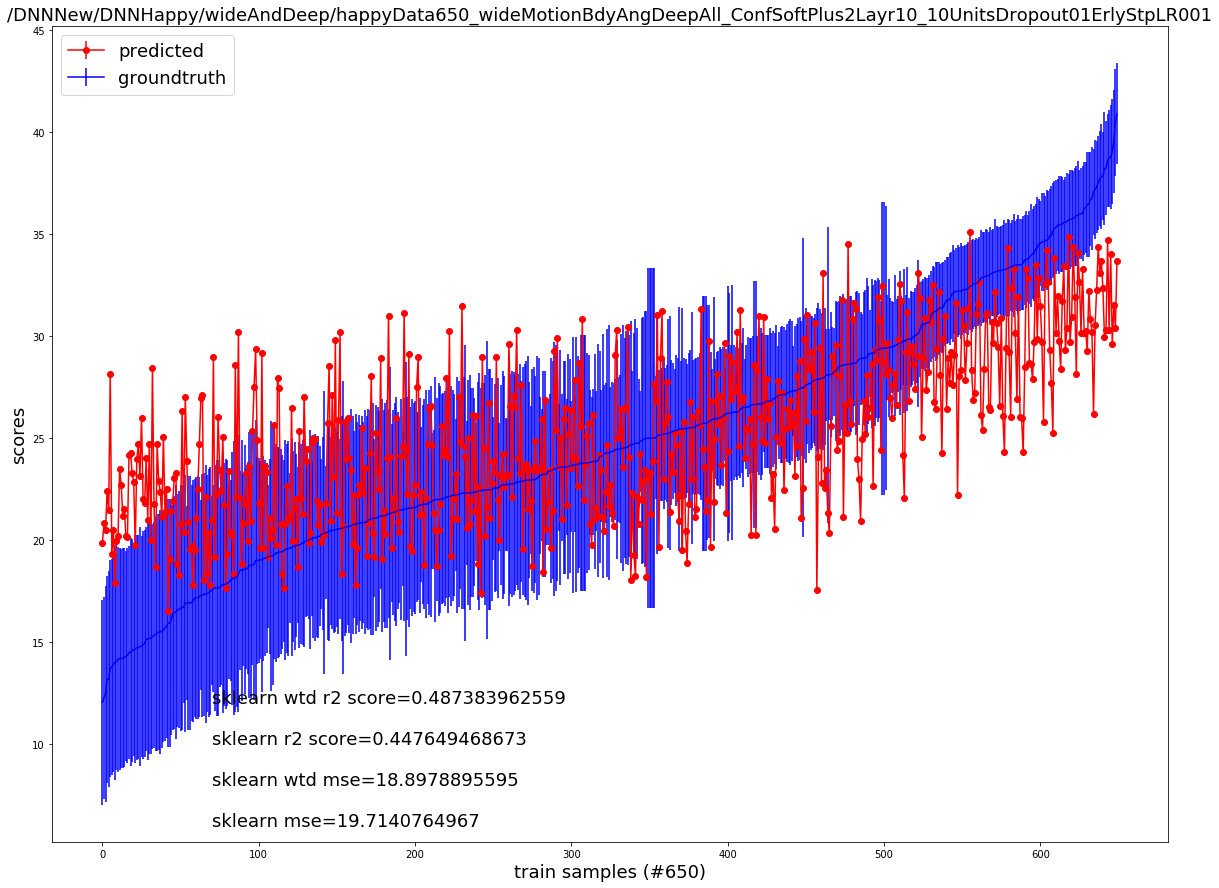

In [25]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train[predicted_name_train].size, 1)
plt.errorbar(x,y_all_sorted_train[predicted_name_train].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted_train[LABEL].values,yerr=y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(inputY_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 

In [26]:
# feature_spec = tf.feature_column.make_parse_example_spec(feature_cols)

# feature_spec

#  export_input_fn = tf.contrib.learn.utils.build_parsing_serving_input_fn(feature_spec)
# #export_input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_spec)

# export_input_fn

# servable_model_dir = "\DNNNew\DNNHappy\wideAndDeep\exportmodel"

# servable_model_path = regressor.export_savedmodel(export_dir_base = servable_model_dir, serving_input_fn = export_input_fn, as_text= True)

# servable_model_path

In [27]:
#servable_model_path2 = regressor.export(servable_model_dir, get_input_fn(X_test_all_wts, y_test, LABEL))

In [28]:
#saver = tf.train.Saver()

In [29]:
# features = regressor._get_features_from_input_fn(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))

# infer_ops = regressor._get_predict_ops(features)
# infer_ops

# predictions = regressor._filter_predictions(infer_ops.predictions, 'scores')

# predictions

# y_predicted_test = list(itertools.islice(predictions,y_test[LABEL].size))

# y_predicted_test

# features

# from tensorflow.python.training import monitored_session
# mon_sess = monitored_session.MonitoredSession(session_creator=monitored_session.ChiefSessionCreator(
#               checkpoint_filename_with_path=model_dir_name+"/model.ckpt-4403",
#               scaffold=infer_ops.scaffold))

# preds = regressor._predict_generator(mon_sess, predictions, [], False)

# preds1 = (pred['scores'] for pred in preds)

# y_predicted_test = list(itertools.islice(preds1,y_test[LABEL].size))

# y_predicted_test

In [30]:
# from tensorflow.python.tools import freeze_graph
# checkpoint_state_name = "model.ckpt-4954"
# input_graph_name = "graph.pbtxt"
# output_graph_name = "output_graph.pb"
# checkpoint_path = os.path.join(model_dir_name, checkpoint_state_name)

# input_graph_path = os.path.join(model_dir_name, input_graph_name)
# input_saver_def_path = None
# input_binary = False
# output_node_names = "output"
# restore_op_name = []#"save/restore_all"
# filename_tensor_name = []#"save/Const:0"
# output_graph_path = os.path.join(model_dir_name, output_graph_name)
# clear_devices = True

# freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
#                           input_binary, checkpoint_path,
#                           output_node_names, restore_op_name,
#                           filename_tensor_name, output_graph_path,
#                           clear_devices, "")

In [31]:
# tf.__version__